In [ ]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
from torchvision import datasets, models, transforms
import torchvision.transforms as transforms
import torch.optim as optim
from pathlib import Path
import matplotlib.pyplot as plt
from torchsummary import summary
import time
print("PyTorch Version: ", torch.__version__)
print("Torchvision Version: ", torchvision.__version__)
!mkdir data
data_dir = Path('./data')
net_fn = Path('./net')
import math
torch.manual_seed(0)
np.random.seed(0)
from prettytable import PrettyTable
!pip install pthflops
from pthflops import count_ops
import copy
!pip install torchinfo
import torchinfo
!pip install thop
from thop import profile
torch.manual_seed(0)
np.random.seed(0)
!pip install --upgrade efficientnet_pytorch
from efficientnet_pytorch import EfficientNet
from scipy.linalg import svd

PyTorch Version:  1.13.0+cu116
Torchvision Version:  0.14.0+cu116
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=8421fbceefe60d7562edbe39febdd723b9372f1ec18d914484ea2cc8c79c7ffa
  Stored in directory: /root/.cache/pip/wheels/84/b9/90/25a0195cf95fb5533db96f1c77ea3f296b7cc86ae8ae48e3dc
Successfully built efficientnet-pytorch


In [ ]:
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
# Mount data directory to google drive
"""
Used the comments in code to execute the file, when used with an account 
that has access to the shared folder of the class, the code will automatically run
"""
from google.colab import drive
drive.mount('./drive')

# Copy to local for faster extraction
!cp drive/Shareddrives/penn-ese-5390-202230/ILSVRC2012_img_val.tar ./data
!cp drive/Shareddrives/penn-ese-5390-202230/ILSVRC2012_devkit_t3.tar.gz ./data
!cp drive/Shareddrives/penn-ese-5390-202230/ILSVRC2012_devkit_t12.tar.gz ./data

# Create transform to preprocess data
val_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# from google.colab import drive
# drive.mount('/content/drive')

# # Copy to local for faster extraction
# !cp /content/drive/Shareddrives/539/ILSVRC2012_img_val.tar ./data
# !cp /content/drive/Shareddrives/539/ILSVRC2012_devkit_t3.tar.gz ./data
# !cp /content/drive/Shareddrives/539/ILSVRC2012_devkit_t12.tar.gz ./data

# val_transform = transforms.Compose([
#     transforms.Resize(224),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# Create validation dataset
val_dataset = datasets.ImageNet('./data', split='val', transform=val_transform)

# Create validation dataloader
val_dataloader = torch.utils.data.DataLoader(val_dataset, num_workers=4)

print(f'Number of validation images: {len(val_dataset)}')


Mounted at /content/drive
Number of validation images: 50000


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
def validate_model(model, dataloader, device="cpu", n=None):
    model.eval()
    running_corrects = 0
    total = 0

    # Move model to device (CPU or GPU)
    # One time to amortize data movement
    dev = torch.device(device)
    model.to(dev)

    # Iterate over data stopping early if n is set
    for i, (inputs, labels) in enumerate(dataloader):
        if (n is not None and i >= n):
            break
        # Send inputs to device
        inputs = inputs.to(dev)

        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        
        """
        """
        temp = labels.data
        if(device=="cuda"):
          temp = temp.to(device="cuda")


        # Gather statistics
        running_corrects += torch.sum(predicted == temp)
        total += inputs.size()[0]       # get batch size

        if i % 200 == 199:
            acc = 100 * running_corrects.double() / total
            print(f'[{i + 1}] {acc:.4f}%')

    epoch_acc = 100 * running_corrects.double() / total

    return epoch_acc


In [ ]:
def compare_models(model_1, model_2):
    # Move models to specified device
    model_1 = model_1.to(dev)
    model_2 = model_2.to(dev)
    
    # Initialize counter for number of differences between models
    models_differ = 0
    
    # Iterate over keys and values of state dictionaries in parallel
    for key_1, value_1, key_2, value_2 in zip(model_1.state_dict().keys(), model_1.state_dict().values(), model_2.state_dict().keys(), model_2.state_dict().values()):
        # If keys are not the same, raise exception
        if key_1 != key_2:
            raise Exception('Mismatch in keys of model state dictionaries')
        # If values are not equal, check if key contains 'weight' and increment counter
        if not torch.equal(value_1, value_2):
            if 'weight' not in key_1:
                models_differ += 1
                print('Mismatch found at', key_1)
    # If counter is 0, print message indicating models match perfectly
    if models_differ == 0:
        print('Models match perfectly! :)')


In [ ]:
def count_parameters(model):
  
    table = PrettyTable(["Modules", "Parameters"])# Initialize table and total parameter count
    total_params = 0
    for name, parameter in model.named_parameters(): # Iterate over model's named parameters
        if not parameter.requires_grad: continue # Skip parameters that do not require gradients
        params = parameter.numel()# Get number of parameters and add to table and total count
        table.add_row([name, params])
        total_params+=params
    # print(table)
    # print(f"Total Trainable Params: {total_params}")
    return total_params

In [ ]:
def _flops(layer, ip):
    input = torch.randn(1, ip, 224, 224) # Generate random input tensor
    flops, params = profile(layer, inputs=input) # Calculate FLOPS and number of parameters for the layer
    return flops

In [ ]:
model_resnet = models.resnet18(pretrained=True)
model_resnet = model_resnet.to(dev)
# summary(model_resnet, input_size = (3,224,224))

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
print(torchinfo.summary(model_resnet, (3, 224, 224), batch_dim = 0, col_names = ("input_size", "output_size", "num_params", "kernel_size", "mult_adds"), verbose = 0))

The following code is to simulate image scaling for phi values from 0 to 7

In [ ]:
"""
phi = 0
"""
ip = torch.rand(1,3,224,224).to(dev)
temp = count_ops(model_resnet, ip) # Count the number of FLOPs

Operation               OPS         
----------------------  ----------  
conv1                   118013952   
bn1                     1605632     
relu                    1605632     
maxpool                 1605632     
layer1_0_conv1          115605504   
layer1_0_bn1            401408      
layer1_0_relu           401408      
layer1_0_conv2          115605504   
layer1_0_bn2            401408      
add                     401408      
layer1_0_relu_1         401408      
layer1_1_conv1          115605504   
layer1_1_bn1            401408      
layer1_1_relu           401408      
layer1_1_conv2          115605504   
layer1_1_bn2            401408      
add_1                   401408      
layer1_1_relu_1         401408      
layer2_0_conv1          57802752    
layer2_0_bn1            200704      
layer2_0_relu           200704      
layer2_0_conv2          115605504   
layer2_0_bn2            200704      
layer2_0_downsample_0   6422528     
layer2_0_downsample_1   200704      
a

In [ ]:
"""
phi = 1
"""
phi = 1
mul = math.pow(math.sqrt(2),phi)
ip = torch.rand(1,3,math.ceil(mul*224),math.ceil(mul*224)).to(dev)
temp = count_ops(model_resnet, ip) # Count the number of FLOPs

Operation               OPS         
----------------------  ----------  
conv1                   237843648   
bn1                     3235968     
relu                    3235968     
maxpool                 3276800     
layer1_0_conv1          235929600   
layer1_0_bn1            819200      
layer1_0_relu           819200      
layer1_0_conv2          235929600   
layer1_0_bn2            819200      
add                     819200      
layer1_0_relu_1         819200      
layer1_1_conv1          235929600   
layer1_1_bn1            819200      
layer1_1_relu           819200      
layer1_1_conv2          235929600   
layer1_1_bn2            819200      
add_1                   819200      
layer1_1_relu_1         819200      
layer2_0_conv1          117964800   
layer2_0_bn1            409600      
layer2_0_relu           409600      
layer2_0_conv2          235929600   
layer2_0_bn2            409600      
layer2_0_downsample_0   13107200    
layer2_0_downsample_1   409600      
a

In [ ]:
"""
phi = 2
"""
phi = 2
mul = math.pow(math.sqrt(2),phi)
ip = torch.rand(1,3,math.ceil(mul*224),math.ceil(mul*224)).to(dev)
temp = count_ops(model_resnet, ip) # Count the number of FLOPs

Operation               OPS         
----------------------  ----------  
conv1                   476280000   
bn1                     6480000     
relu                    6480000     
maxpool                 6537728     
layer1_0_conv1          470716416   
layer1_0_bn1            1634432     
layer1_0_relu           1634432     
layer1_0_conv2          470716416   
layer1_0_bn2            1634432     
add                     1634432     
layer1_0_relu_1         1634432     
layer1_1_conv1          470716416   
layer1_1_bn1            1634432     
layer1_1_relu           1634432     
layer1_1_conv2          470716416   
layer1_1_bn2            1634432     
add_1                   1634432     
layer1_1_relu_1         1634432     
layer2_0_conv1          239542272   
layer2_0_bn1            831744      
layer2_0_relu           831744      
layer2_0_conv2          479084544   
layer2_0_bn2            831744      
layer2_0_downsample_0   26615808    
layer2_0_downsample_1   831744      
a

In [ ]:
"""
phi = 3
"""
phi = 3
mul = math.pow(math.sqrt(2),phi)
ip = torch.rand(1,3,math.ceil(mul*224),math.ceil(mul*224)).to(dev)
temp = count_ops(model_resnet, ip) # Count the number of FLOPs

Operation               OPS         
----------------------  ----------  
conv1                   945400512   
bn1                     12862592    
relu                    12862592    
maxpool                 12943872    
layer1_0_conv1          931958784   
layer1_0_bn1            3235968     
layer1_0_relu           3235968     
layer1_0_conv2          931958784   
layer1_0_bn2            3235968     
add                     3235968     
layer1_0_relu_1         3235968     
layer1_1_conv1          931958784   
layer1_1_bn1            3235968     
layer1_1_relu           3235968     
layer1_1_conv2          931958784   
layer1_1_bn2            3235968     
add_1                   3235968     
layer1_1_relu_1         3235968     
layer2_0_conv1          471859200   
layer2_0_bn1            1638400     
layer2_0_relu           1638400     
layer2_0_conv2          943718400   
layer2_0_bn2            1638400     
layer2_0_downsample_0   52428800    
layer2_0_downsample_1   1638400     
a

In [ ]:
"""
phi = 4
"""
phi = 4
mul = math.pow(math.sqrt(2),phi)
ip = torch.rand(1,3,math.ceil(mul*224),math.ceil(mul*224)).to(dev)
temp = count_ops(model_resnet, ip) # Count the number of FLOPs

Operation               OPS          
----------------------  -----------  
conv1                   1896662208   
bn1                     25804928     
relu                    25804928     
maxpool                 25920000     
layer1_0_conv1          1866240000   
layer1_0_bn1            6480000      
layer1_0_relu           6480000      
layer1_0_conv2          1866240000   
layer1_0_bn2            6480000      
add                     6480000      
layer1_0_relu_1         6480000      
layer1_1_conv1          1866240000   
layer1_1_bn1            6480000      
layer1_1_relu           6480000      
layer1_1_conv2          1866240000   
layer1_1_bn2            6480000      
add_1                   6480000      
layer1_1_relu_1         6480000      
layer2_0_conv1          941432832    
layer2_0_bn1            3268864      
layer2_0_relu           3268864      
layer2_0_conv2          1882865664   
layer2_0_bn2            3268864      
layer2_0_downsample_0   104603648    
layer2_0_dow

In [ ]:
"""
phi = 5
"""
phi = 5
mul = math.pow(math.sqrt(2),phi)
ip = torch.rand(1,3,math.ceil(mul*224),math.ceil(mul*224)).to(dev)
temp = count_ops(model_resnet, ip) # Count the number of FLOPs

Operation               OPS          
----------------------  -----------  
conv1                   3781602048   
bn1                     51450368     
relu                    51450368     
maxpool                 51450368     
layer1_0_conv1          3704426496   
layer1_0_bn1            12862592     
layer1_0_relu           12862592     
layer1_0_conv2          3704426496   
layer1_0_bn2            12862592     
add                     12862592     
layer1_0_relu_1         12862592     
layer1_1_conv1          3704426496   
layer1_1_bn1            12862592     
layer1_1_relu           12862592     
layer1_1_conv2          3704426496   
layer1_1_bn2            12862592     
add_1                   12862592     
layer1_1_relu_1         12862592     
layer2_0_conv1          1863917568   
layer2_0_bn1            6471936      
layer2_0_relu           6471936      
layer2_0_conv2          3727835136   
layer2_0_bn2            6471936      
layer2_0_downsample_0   207101952    
layer2_0_dow

In [ ]:
"""
phi = 6
"""
phi = 6
mul = math.pow(math.sqrt(2),phi)
ip = torch.rand(1,3,math.ceil(mul*224),math.ceil(mul*224)).to(dev)
temp = count_ops(model_resnet, ip) # Count the number of FLOPs

Operation               OPS          
----------------------  -----------  
conv1                   7569761472   
bn1                     102989952    
relu                    102989952    
maxpool                 103219712    
layer1_0_conv1          7431819264   
layer1_0_bn1            25804928     
layer1_0_relu           25804928     
layer1_0_conv2          7431819264   
layer1_0_bn2            25804928     
add                     25804928     
layer1_0_relu_1         25804928     
layer1_1_conv1          7431819264   
layer1_1_bn1            25804928     
layer1_1_relu           25804928     
layer1_1_conv2          7431819264   
layer1_1_bn2            25804928     
add_1                   25804928     
layer1_1_relu_1         25804928     
layer2_0_conv1          3732480000   
layer2_0_bn1            12960000     
layer2_0_relu           12960000     
layer2_0_conv2          7464960000   
layer2_0_bn2            12960000     
layer2_0_downsample_0   414720000    
layer2_0_dow

In [ ]:
"""
phi = 7
"""
phi = 7
mul = math.pow(math.sqrt(2),phi)
ip = torch.rand(1,3,math.ceil(mul*224),math.ceil(mul*224)).to(dev)
temp = count_ops(model_resnet, ip) # Count the number of FLOPs

Operation               OPS           
----------------------  ------------  
conv1                   15126408192   
bn1                     205801472     
relu                    205801472     
maxpool                 205801472     
layer1_0_conv1          14817705984   
layer1_0_bn1            51450368      
layer1_0_relu           51450368      
layer1_0_conv2          14817705984   
layer1_0_bn2            51450368      
add                     51450368      
layer1_0_relu_1         51450368      
layer1_1_conv1          14817705984   
layer1_1_bn1            51450368      
layer1_1_relu           51450368      
layer1_1_conv2          14817705984   
layer1_1_bn2            51450368      
add_1                   51450368      
layer1_1_relu_1         51450368      
layer2_0_conv1          7408852992    
layer2_0_bn1            25725184      
layer2_0_relu           25725184      
layer2_0_conv2          14817705984   
layer2_0_bn2            25725184      
layer2_0_downsample_0   8

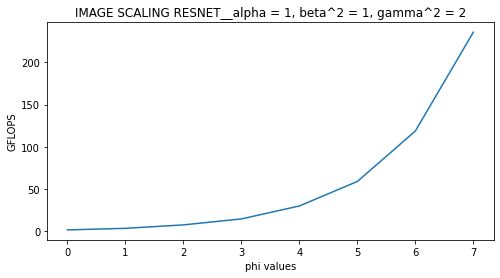

In [ ]:
x_val_resnet18_image_scaling = [0,1,2,3,4,5,6,7] #plotting the results
y_val_resnet18_image_scaling = [1.83, 3.72, 7.77, 14.84, 30.13, 59.11, 118.69, 235.452 ]
plt.figure(figsize=(8,4))
plt.title("IMAGE SCALING RESNET__alpha = 1, beta^2 = 1, gamma^2 = 2")
plt.xlabel("phi values")
plt.ylabel("GFLOPS")
plt.plot(x_val_resnet18_image_scaling, y_val_resnet18_image_scaling)

In [ ]:
net = copy.deepcopy(model_resnet)
for name, child in net.named_children():
  print(name)

conv1
bn1
relu
maxpool
layer1
layer2
layer3
layer4
avgpool
fc


In [ ]:
compare_models(net, model_resnet)

Models match perfectly! :)


In [ ]:
def print_count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params


In [ ]:
phi = 1

In [ ]:
net.conv1 = nn.Conv2d(math.ceil(3), math.ceil(phi*64), kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
net.bn1 = nn.BatchNorm2d(math.ceil(phi*64), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net.relu = nn.ReLU(inplace=True)
net.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

net.layer1[0].conv1 = nn.Conv2d(math.ceil(phi*64), math.ceil(phi*64), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
net.layer1[0].bn1 = nn.BatchNorm2d(math.ceil(phi*64), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net.layer1[0].relu = nn.ReLU(inplace=True)
net.layer1[0].conv2 = nn.Conv2d(math.ceil(phi*64), math.ceil(phi*64), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
net.layer1[0].bn2 = nn.BatchNorm2d(math.ceil(phi*64), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net.layer1[1].conv1 = nn.Conv2d(math.ceil(phi*64), math.ceil(phi*64), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
net.layer1[1].bn1 = nn.BatchNorm2d(math.ceil(phi*64), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net.layer1[1].relu = nn.ReLU(inplace=True)
net.layer1[1].conv2 = nn.Conv2d(math.ceil(phi*64),math.ceil(phi* 64), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
net.layer1[1].bn2 = nn.BatchNorm2d(math.ceil(phi*64), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

net.layer2[0].conv1 = nn.Conv2d(math.ceil(phi*64), math.ceil(phi*128), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
net.layer2[0].bn1 = nn.BatchNorm2d(math.ceil(phi*128), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net.layer2[0].relu = nn.ReLU(inplace=True)
net.layer2[0].conv2 = nn.Conv2d(math.ceil(phi*128),math.ceil(phi*128), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
net.layer2[0].bn2 = nn.BatchNorm2d(math.ceil(phi*128), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net.layer2[0].downsample[0] = nn.Conv2d(math.ceil(phi*64), math.ceil(phi*128), kernel_size=(1, 1), stride=(2, 2), bias=False)
net.layer2[0].downsample[1] = nn.BatchNorm2d(math.ceil(phi*128), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net.layer2[1].conv1 = nn.Conv2d(math.ceil(phi*128), math.ceil(phi*128), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
net.layer2[1].bn1 = nn.BatchNorm2d(math.ceil(phi*128), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net.layer2[1].relu = nn.ReLU(inplace=True)
net.layer2[1].conv2 = nn.Conv2d(math.ceil(phi*128), math.ceil(phi*128), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
net.layer2[1].bn2 = nn.BatchNorm2d(math.ceil(phi*128), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

net.layer3[0].conv1 = nn.Conv2d(math.ceil(phi*128), math.ceil(phi*256), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
net.layer3[0].bn1 = nn.BatchNorm2d(math.ceil(phi*256), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net.layer3[0].relu = nn.ReLU(inplace=True)
net.layer3[0].conv2 = nn.Conv2d(math.ceil(phi*256), math.ceil(phi*256), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
net.layer3[0].bn2 = nn.BatchNorm2d(math.ceil(phi*256), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net.layer3[0].downsample[0] = nn.Conv2d(math.ceil(phi*128), math.ceil(phi*256), kernel_size=(1, 1), stride=(2, 2), bias=False)
net.layer3[0].downsample[1] = nn.BatchNorm2d(math.ceil(phi*256), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net.layer3[1].conv1 = nn.Conv2d(math.ceil(phi*256), math.ceil(phi*256), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
net.layer3[1].bn1 = nn.BatchNorm2d(math.ceil(phi*256), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net.layer3[1].relu = nn.ReLU(inplace=True)
net.layer3[1].conv2 = nn.Conv2d(math.ceil(phi*256), math.ceil(phi*256), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
net.layer3[1].bn2 = nn.BatchNorm2d(math.ceil(phi*256), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

net.layer4[0].conv1 = nn.Conv2d(math.ceil(phi*256), math.ceil(phi*512), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
net.layer4[0].bn1 = nn.BatchNorm2d(math.ceil(phi*512), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net.layer4[0].relu = nn.ReLU(inplace=True)
net.layer4[0].conv2 = nn.Conv2d(math.ceil(phi*512), math.ceil(phi*512), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
net.layer4[0].bn2 = nn.BatchNorm2d(math.ceil(phi*512), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net.layer4[0].downsample[0] = nn.Conv2d(math.ceil(phi*256), math.ceil(phi*512), kernel_size=(1, 1), stride=(2, 2), bias=False)
net.layer4[0].downsample[1] = nn.BatchNorm2d(math.ceil(phi*512), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net.layer4[1].conv1 = nn.Conv2d(math.ceil(phi*512), math.ceil(phi*512), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
net.layer4[1].bn1 = nn.BatchNorm2d(math.ceil(phi*512), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
net.layer4[1].relu = nn.ReLU(inplace=True)
net.layer4[1].conv2 = nn.Conv2d(math.ceil(phi*512), math.ceil(phi*512), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
net.layer4[1].bn2 = nn.BatchNorm2d(math.ceil(phi*512), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
# net.avgpool = Identity()
net.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
nn.fc = nn.Linear(in_features=math.ceil(phi*512), out_features=1000, bias=True)

In [ ]:
y_val_resnet18_width_scaling = []
x_val_resnet18_width_scaling = [0,1,2,3,4,5,6,7]
for each in x_val_resnet18_width_scaling:
  phi = math.pow(math.sqrt(2), each)
  # net.conv1 = nn.Conv2d(math.ceil(phi*3), math.ceil(phi*64), kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  net.conv1 = nn.Conv2d(math.ceil(3), math.ceil(phi*64), kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  net.bn1 = nn.BatchNorm2d(math.ceil(phi*64), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net.relu = nn.ReLU(inplace=True)
  net.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)

  net.layer1[0].conv1 = nn.Conv2d(math.ceil(phi*64), math.ceil(phi*64), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  net.layer1[0].bn1 = nn.BatchNorm2d(math.ceil(phi*64), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net.layer1[0].relu = nn.ReLU(inplace=True)
  net.layer1[0].conv2 = nn.Conv2d(math.ceil(phi*64), math.ceil(phi*64), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  net.layer1[0].bn2 = nn.BatchNorm2d(math.ceil(phi*64), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net.layer1[1].conv1 = nn.Conv2d(math.ceil(phi*64), math.ceil(phi*64), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  net.layer1[1].bn1 = nn.BatchNorm2d(math.ceil(phi*64), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net.layer1[1].relu = nn.ReLU(inplace=True)
  net.layer1[1].conv2 = nn.Conv2d(math.ceil(phi*64),math.ceil(phi* 64), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  net.layer1[1].bn2 = nn.BatchNorm2d(math.ceil(phi*64), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  net.layer2[0].conv1 = nn.Conv2d(math.ceil(phi*64), math.ceil(phi*128), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  net.layer2[0].bn1 = nn.BatchNorm2d(math.ceil(phi*128), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net.layer2[0].relu = nn.ReLU(inplace=True)
  net.layer2[0].conv2 = nn.Conv2d(math.ceil(phi*128),math.ceil(phi*128), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  net.layer2[0].bn2 = nn.BatchNorm2d(math.ceil(phi*128), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net.layer2[0].downsample[0] = nn.Conv2d(math.ceil(phi*128), math.ceil(phi*128), kernel_size=(1, 1), stride=(2, 2), bias=False)
  net.layer2[0].downsample[1] = nn.BatchNorm2d(math.ceil(phi*128), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net.layer2[1].conv1 = nn.Conv2d(math.ceil(phi*128), math.ceil(phi*128), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  net.layer2[1].bn1 = nn.BatchNorm2d(math.ceil(phi*128), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net.layer2[1].relu = nn.ReLU(inplace=True)
  net.layer2[1].conv2 = nn.Conv2d(math.ceil(phi*128), math.ceil(phi*128), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  net.layer2[1].bn2 = nn.BatchNorm2d(math.ceil(phi*128), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  net.layer3[0].conv1 = nn.Conv2d(math.ceil(phi*128), math.ceil(phi*256), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  net.layer3[0].bn1 = nn.BatchNorm2d(math.ceil(phi*256), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net.layer3[0].relu = nn.ReLU(inplace=True)
  net.layer3[0].conv2 = nn.Conv2d(math.ceil(phi*256), math.ceil(phi*256), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  net.layer3[0].bn2 = nn.BatchNorm2d(math.ceil(phi*256), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net.layer3[0].downsample[0] = nn.Conv2d(math.ceil(phi*256), math.ceil(phi*256), kernel_size=(1, 1), stride=(2, 2), bias=False)
  net.layer3[0].downsample[1] = nn.BatchNorm2d(math.ceil(phi*256), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net.layer3[1].conv1 = nn.Conv2d(math.ceil(phi*256), math.ceil(phi*256), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  net.layer3[1].bn1 = nn.BatchNorm2d(math.ceil(phi*256), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net.layer3[1].relu = nn.ReLU(inplace=True)
  net.layer3[1].conv2 = nn.Conv2d(math.ceil(phi*256), math.ceil(phi*256), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  net.layer3[1].bn2 = nn.BatchNorm2d(math.ceil(phi*256), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

  net.layer4[0].conv1 = nn.Conv2d(math.ceil(phi*256), math.ceil(phi*512), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  net.layer4[0].bn1 = nn.BatchNorm2d(math.ceil(phi*512), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net.layer4[0].relu = nn.ReLU(inplace=True)
  net.layer4[0].conv2 = nn.Conv2d(math.ceil(phi*512), math.ceil(phi*512), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  net.layer4[0].bn2 = nn.BatchNorm2d(math.ceil(phi*512), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net.layer4[0].downsample[0] = nn.Conv2d(math.ceil(phi*512), math.ceil(phi*512), kernel_size=(1, 1), stride=(2, 2), bias=False)
  net.layer4[0].downsample[1] = nn.BatchNorm2d(math.ceil(phi*512), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net.layer4[1].conv1 = nn.Conv2d(math.ceil(phi*512), math.ceil(phi*512), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  net.layer4[1].bn1 = nn.BatchNorm2d(math.ceil(phi*512), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  net.layer4[1].relu = nn.ReLU(inplace=True)
  net.layer4[1].conv2 = nn.Conv2d(math.ceil(phi*512), math.ceil(phi*512), kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  net.layer4[1].bn2 = nn.BatchNorm2d(math.ceil(phi*512), eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  # net.avgpool = Identity()
  net.avgpool = nn.AdaptiveAvgPool2d(output_size=(1, 1))
  nn.fc = nn.Linear(in_features=math.ceil(phi*512), out_features=1000, bias=True)
  temp_count = count_parameters(net)
  y_val_resnet18_width_scaling.append(temp_count)

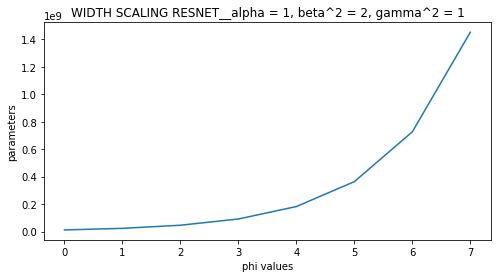

In [ ]:
plt.figure(figsize=(8,4))
plt.title("WIDTH SCALING RESNET__alpha = 1, beta^2 = 2, gamma^2 = 1")
plt.xlabel("phi values")
plt.ylabel("parameters")
plt.plot(x_val_resnet18_width_scaling, y_val_resnet18_width_scaling)